# Homicide Reports Data In The US
<h4>Khanh Nguyen, Marc Hipona</h4>
<h2>Overview</h2>
<p>Homicides happen everyday in our lives. It is important to be aware of increasing crime rate in the US in order to implement safety measurements. From that, this tutorial introduces a deep analysis on homicide reports in the US from 1980 to 2014. The tutorial includes three main parts. The first part will include data collecting and data cleaning processes. The second part will demonstrate how to analyze the given data and display visualization. The third part will come up with a linear regression model to process the analysis and verify the hypotheses implied from it.</p>
<h2>Required Tools</h2>
<p>We recommend using Jupyter Notebook since Python is included and it is a great editor for data analysis. You will also need to following libraries:</p>
<ul>
<li>pandas</li>
<li>numpy</li>
<li>scikit-learn</li>
<li>matplotlib</li>
<li>folium</li>
</ul>
<p>For the dataset, the homicide reports data can be retrived at https://www.kaggle.com/murderaccountability/homicide-reports/data</p>

<h2>Part 1: Data Preparation</h2>
<p>The first thing we need to do is download the dataset at https://www.kaggle.com/murderaccountability/homicide-reports/data. The file downloaded will be in form of a CSV (comma-separated value) called database.csv. Then, we have to load the file to our Jupyter Notebook in order to process the data within it. To do this, pandas libraries will help us initialize the data in nice frames and columns. If you are unfamiliar with pandas, its documentation can be found at:</p>
<ul>
<li>Complete Documentation: https://pandas.pydata.org/pandas-docs/stable/</li>
<li>Pandas Cheat Sheet: https://www.datacamp.com/community/blog/python-pandas-cheat-sheet</li>
</ul>

In [139]:
#Import needed libraries
!pip install folium
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from sklearn import linear_model
import os
from branca.utilities import split_six
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [140]:
#Load the csv file and make dataframe
data = pd.read_csv("database.csv", dtype=object)
#Display the first 5 rows of the table
data.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,000001,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,000002,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,000003,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,000004,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,000005,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


<h3>1.1 Data Overview</h3>
<p>The data contains some crucial information for us to analyze such as the time, locations, crime types, weapons, victim, and perpentrator info.</p> 
<h3>1.2 Data Tidying</h3>
<p>When we look at the data table, there are several columns that seem to be unnecessary to our analysis such as the Agency Code, Agency Name, Record Source, etc. In this case, we drop these columns since we do not need them for our analysis.</p>

In [141]:
#drop all unnecessary columns
data = data.drop('Agency Code', 1)
data = data.drop('Agency Name', 1)
data = data.drop('Agency Type', 1)
data = data.drop('Record Source', 1)
data = data.drop('Month', 1)
data = data.drop('Perpetrator Ethnicity', 1)
data = data.drop('Victim Ethnicity', 1)
#Convert Year data to int
data['Year'] = data['Year'].str.replace(")", "").astype(int)

<p>Next, in order to serve the purpose of the analysis, we separate victims and perpetrators into two different tables with columns associate with them. Note that in order to identify the case for each row, we will use Record ID column to do that for each table.</p>

In [142]:
#Create victim table
victim_data = pd.DataFrame(data[['Record ID','City','State','Year','Crime Type','Victim Sex','Victim Age', \
                                 'Victim Count']])
victim_data.head()

,Record ID,City,State,Year,Crime Type,Victim Sex,Victim Age,Victim Count
0,000001,Anchorage,Alaska,1980,Murder or Manslaughter,Male,14,0
1,000002,Anchorage,Alaska,1980,Murder or Manslaughter,Male,43,0
2,000003,Anchorage,Alaska,1980,Murder or Manslaughter,Female,30,0
3,000004,Anchorage,Alaska,1980,Murder or Manslaughter,Male,43,0
4,000005,Anchorage,Alaska,1980,Murder or Manslaughter,Female,30,0


<p>If we look at the original table, we will notice that there are some cases that were unsolved (under Crime Solved column) and perpetrator's age is 0. In these cases, the identity of the perpentrator is unknown but it happened to have victims. Therefore, since we are separating victims and perpetrators, it makes sense if we cut off the rows that have cases unsolved and perpetrator's age is 0.</p>

In [143]:
#Create perpetrator table
ped_data = pd.DataFrame(data[['Record ID','City','State','Year','Crime Type','Crime Solved','Perpetrator Sex', \
                              'Perpetrator Age','Weapon','Perpetrator Count']])
#Cut off any cases that were unsolved
ped_data = ped_data[ped_data['Crime Solved'] != 'No']
#Cut off any cases that perpetrator's age is 0
ped_data = ped_data[ped_data['Perpetrator Age'] != '0']
#Change the type of perpetrator age column
ped_data['Perpetrator Age'] = ped_data['Perpetrator Age'].str.replace(")", "").astype(int)
ped_data.head()

,Record ID,City,State,Year,Crime Type,Crime Solved,Perpetrator Sex,Perpetrator Age,Weapon,Perpetrator Count
0,000001,Anchorage,Alaska,1980,Murder or Manslaughter,Yes,Male,15,Blunt Object,0
1,000002,Anchorage,Alaska,1980,Murder or Manslaughter,Yes,Male,42,Strangulation,0
3,000004,Anchorage,Alaska,1980,Murder or Manslaughter,Yes,Male,42,Strangulation,0
5,000006,Anchorage,Alaska,1980,Murder or Manslaughter,Yes,Male,36,Rifle,0
6,000007,Anchorage,Alaska,1980,Murder or Manslaughter,Yes,Male,27,Knife,0


<h2>Part 2: Data Analysis and Visualization</h2>
<p>At this point, our data is ready to analyze. In this part, we would like to visualize the data we just cleaned up with some plots and map in order to portray and explain the trend of homicides to the audience. Also, statistical measurement for this data is included as well.</p>
<h3>2.1 Homicide By Year</h3>
<p>First thing we would like to analyze is the number of homicides happened throughout the years from 1980 to 2014. We would like to know how this number changed every year in that period and explain the trend of these homicides.</p> 
<h4>2.1.1 Extract the Homicide Number Per Year</h4>
<p>Our data currently has many cases belong to a specific year. The question to ask is: How can we count the number of homicides of a year in that period? Fortunately, pandas' groupby function will help us do the trick. Documentation about pandas' groupby can be found at: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html. The code below will demonstrate how we count the number of homicides per year based on our data.</p>

In [144]:
#Use groupby and count functions to count how many homicides in a year
data_by_year = data.copy().groupby(data['Year'], as_index=True, group_keys=True).count()
#Put indexes into the result table
count_by_year = data_by_year[['Record ID']].reset_index()
#Instead of Record ID, Count should be the name of the column
count_by_year = count_by_year.rename(index=str, columns={'Record ID' : 'Count'})
count_by_year.head()

,Year,Count
0,1980,23092
1,1981,21208
2,1982,20544
3,1983,19653
4,1984,18093


<h4>2.1.2 Visualize Homicides Number With Year</h4>
<p>Now we have successfully extracted the count of how many homicides happened for each year in the period. The next task to do is plotting a graph using the Year and Count columns in the table we did above. One of the great library for this task is matplotlib which allows us to have nice graphs with given dataset we have. More information can be found at https://matplotlib.org/. The code below will demonstate this task.</p>

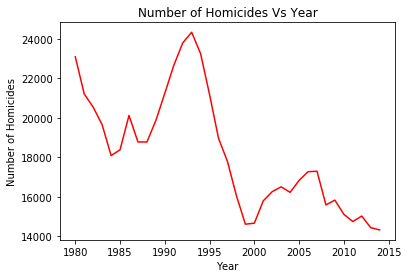

In [145]:
#Put data in plot, Year column is the x-axis, Count column is the y-axis
plt.plot(count_by_year['Year'], count_by_year['Count'], color='red')
#Label y axis
plt.ylabel('Number of Homicides')
#Label x axis
plt.xlabel('Year')
#Give the title of the plot
plt.title('Number of Homicides Vs Year')
#Show it
plt.show()

<p>The trend for the number of homicides seems to decrease by year in general. The number of homicides reached maximum in the period from 1990 to 1995 especially 1994 which has the largest number of homicides. After that, the number seems to be small and up to the most recent year in 2014, the number of homicides is the smallest.</p>
<h4>2.1.3 Statistic Data</h4>
<p>We would like to have some basic statistic for the number of homicides for all years in the period from 1980 to 2014.</p>

In [146]:
print("Each year the average of homicides is: " + str(count_by_year['Count'].mean()) + " homicides/year")
print("The standard deviation of number of homicides is: " + str(count_by_year['Count'].std()))

Each year the average of homicides is: 18241.5428571 homicides/year
The standard deviation of number of homicides is: 2986.44665253


<p>It can be said that the number of homicides is high in average which is 18241 cases per year. Also, the difference among the year is large as well which is showed by a quite large standard deviation.</p>

<h3>2.2 Homicide By State</h3>
<p>It is interesting to know how many homicides happened in each state in the US. Now, we want to introduce how homicides distribute in the US with some cool visualization.</p> 
<h4>2.2.1 Extract the Homicide Number Per State</h4>
<p>We use the same strategy as 2.1.1 but with State column.</p>

In [147]:
data_by_state = data.copy().groupby(data['State'], as_index=True, group_keys=True).count()
count_by_state = data_by_state[['Record ID']].reset_index()
count_by_state = count_by_state.rename(index=str, columns={'Record ID' : 'Count'})
count_by_state.head()

,State,Count
0,Alabama,11376
1,Alaska,1617
2,Arizona,12871
3,Arkansas,6947
4,California,99783


<h4>2.2.2 Visualize Homicide Number With States With Graph</h4>
<p>We have successfully plotted the line graph of homicide number with year. Now, we do similar task but we will use horizontal bar plot in order to show the homicide222 number with states.</p>

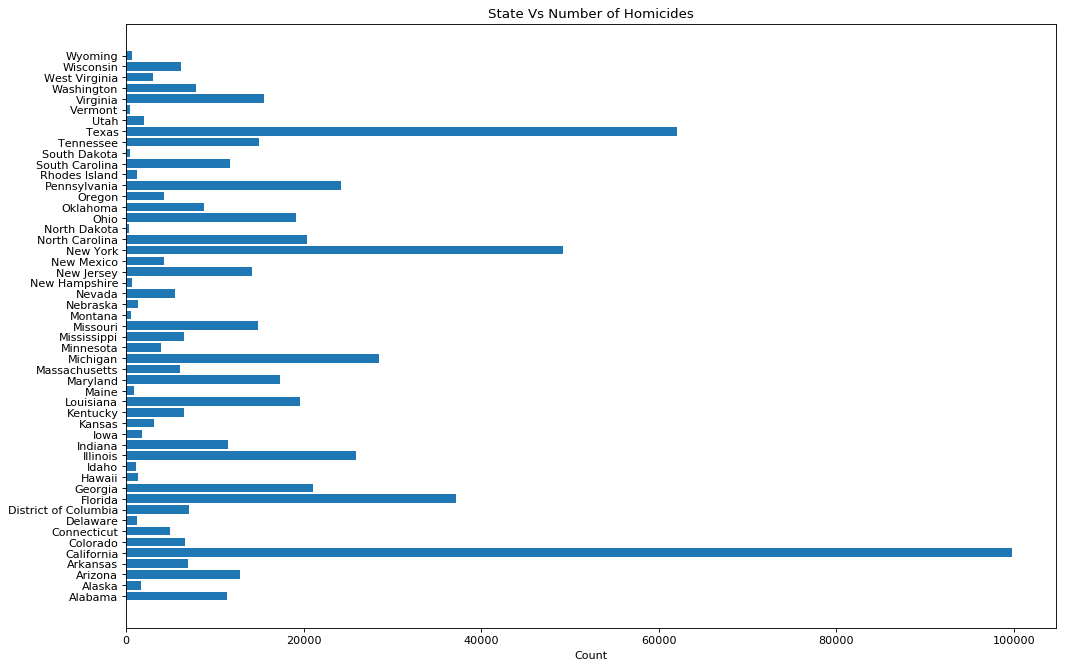

In [148]:
%matplotlib inline
#Initialize the size of the plot
plt.figure(figsize=(15, 10), dpi=80);
#Convert the State column to a numpy array
y_pos = np.arange(len(count_by_state['State']))
#Put the data into the plot
plt.barh(y_pos, count_by_state['Count'])
#Label y-axis
plt.yticks(y_pos, count_by_state['State'])
#Label x-axis
plt.xlabel('Count')
#Create title of the plot
plt.title('State Vs Number of Homicides')

<p>In the common intuition when we look at the graph, the number of homicides in each state seems to be proportional with the size and population of that state. In the graph, it shows that California has the largest number of homicides in this period. The runner-up is Texas and so on. Small number of homicides only happened in small states (in term of size and population) such as Montana, North Dakota, South Dakota, etc.</p>
<h4>2.2.3 Visualize Homicides Number With States With Map</h4>
<p>Here comes the cool part of this section. We would like to illustrate the number of homicides percentage by state on map. Python has a library called folium. In general, folium is a library that allows users to play with maps. More information about folium can be found at https://folium.readthedocs.io/en/latest/. In this section, we want to introduce folium's choropleth map in order to illustrate our data. In order to do this, we will need a file called us-states.json which is a geo json file contains the boundaries of the US States. The purpose of using this file lets us color the states based on the number of homicides. You can download the file by right clicking on the screen and select Save As at this URL: https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json. We will demonstrate how to make the map using the code below.</p>

In [149]:
#Get the percentages of all states over the total of number of homicides
count_by_state['Percentage'] = count_by_state['Count']*100/count_by_state['Count'].sum()
#Some visualization optimization
threshold_scale = split_six(count_by_state['Percentage'])
#Make path for the json file
state_geo = os.path.join('us-states.json')

#Make the map with a start location and zoom size
m = folium.Map(location=[48, -102], zoom_start=3)

#Add choropleth layer in the map using the json file
#Import data from the count_by_state DataFrame with State and Percentage columns
#Set the keys on the state names
#Put in basic features such as color, opacities, legend_name, etc.
m.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=count_by_state,
    columns=['State','Percentage'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Homicides (%)',
    threshold_scale=threshold_scale,
    reset=True
)

folium.LayerControl().add_to(m)
m

<h3>2.3 Number of Perpetrators By Age</h3>
<p>The last analysis we would like to do is the number of perpetrators by age. The analysis plays an important role of determining the average age of perpetrator. This piece of information is useful for everyone to understand why perpetrators at a certain age acts as murderers.</p>
<h4>2.3.1 Extract the Homicides Number by Age</h4>
<p>We will use same strategy as 2.1.1 but we will use the perpetrator table.</p>

In [150]:
data_by_perp_age = ped_data.copy().groupby(ped_data['Perpetrator Age'], as_index=True, group_keys=True).count()
count_by_perp_age = data_by_perp_age[['Record ID']].reset_index()
count_by_perp_age = count_by_perp_age.rename(index=str, columns={'Record ID' : 'Count'})
count_by_perp_age.head()

,Perpetrator Age,Count
0,1,16
1,2,6
2,3,24
3,4,29
4,5,31


<h4>2.3.2 Visualize Homicide Number by Age</h4>
<p>We will visualize the data we retrieved above using the strategy in 2.3.2 but it will be better if we do vertical bar this time.</p>

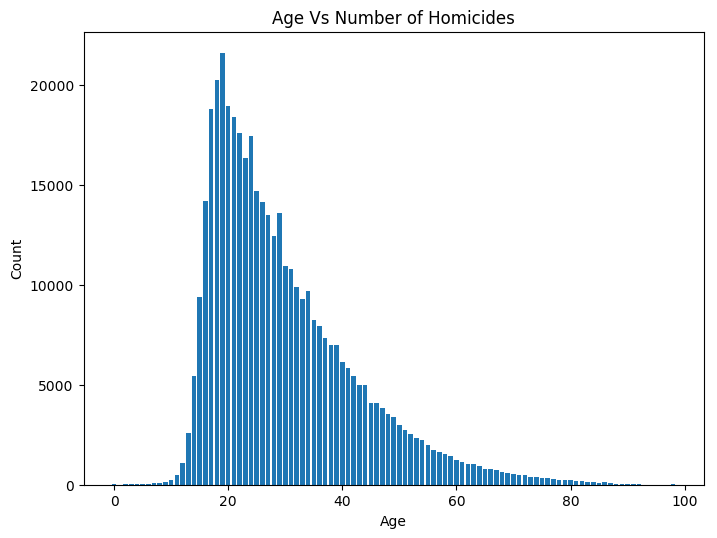

In [151]:
plt.figure(figsize=(8, 6), dpi=100);
y_pos = np.arange(len(count_by_perp_age['Perpetrator Age']))
plt.bar(y_pos, count_by_perp_age['Count'])
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Vs Number of Homicides')

In [152]:
print("The average age of a perpetrator is: " + str(sum(count_by_perp_age['Count']*count_by_perp_age['Perpetrator Age'])/ \
                                                    count_by_perp_age['Count'].sum()) + " years old")

The average age of a perpetrator is: 30.7294434743 years old


<p>The large number of perpetrators happened to be around 18 to 30. This comes to the fact that a perpetrator's average age is around 30. After 30, the number of perpetrators decreases as the age get larger. Also in the graph, the age that has most perpetrators is 19 which seems to be low for a perpetrator. It is noticeable that perpetrators does not appear much outside the working ages.</p>

<h2>Part 3: Linear Regression and Hypothesis Test</h2>
<p>Now that we have our analysis done we can start doing linear regression and test our predictions. When doing a linear regression, we're taking data that is already there and predicting future data base on the patterns of the data we already have. We are going to take a linear regression of just our Homicide vs Year data and compare it to another regression when taking account States using a f test. And we predict that if we can account many factors, we will be able to have more accurate predictions.</p>
<h3>3.1 Linear Regression on Homicide by Years</h3>
<p>We will start creating the linear regression model for Homicide Count vs Years. We will be using the Linear Regression model library to create the model and to get our predicted values.</p>
<p>Refer to the documentation for more info http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html </p>

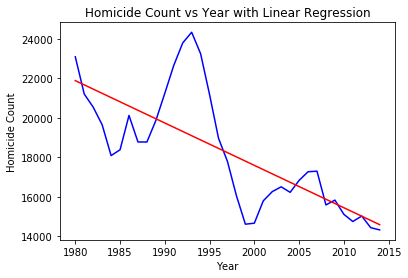

In [153]:
#Linear Regression
reg = linear_model.LinearRegression()
X = [[x] for x in count_by_year['Year'].values]
Y = [[y] for y in count_by_year['Count'].values]
regfit = reg.fit(X, Y)

#Get predcited Values
pred_homicides = []
for x in count_by_year['Year'].values:
    pred_homicides.append(regfit.predict(x)[0][0])
count_by_year['pred_homicides'] = pd.Series(pred_homicides, index = count_by_year.index)

#Plot the linear regression line with the data
plt.plot(count_by_year['Year'], count_by_year['Count'], color='blue',)
plt.plot(count_by_year['Year'], count_by_year['pred_homicides'], color='red')
plt.xlabel("Year")
plt.ylabel("Homicide Count")
plt.title("Homicide Count vs Year with Linear Regression")

<h3>3.2 Fitting the Linear Regression Model</h3>
<p>First we would need to create a new table that will group the data by Year and State so that we can get the number homicides associated with those columns. Next we would like to fit the data we had to the linear regression model. In order to do this we will be using the ols regression library to retrieve the linear regression formula. Documentation can be found at http://www.statsmodels.org/stable/index.html</p>
<p>In this section, we would like to fit two different linear regressions. First is the regression with count associate with year. Second is the regression with both year and state as factors. Here is the result for the first regression:</p>

In [154]:
#Fit the first regression
regression = ols(formula='Count ~ Year', data=data_by_state_year).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     11.80
Date:                Mon, 11 Dec 2017   Prob (F-statistic):           0.000606
Time:                        21:03:29   Log-Likelihood:                -13529.
No. Observations:                1759   AIC:                         2.706e+04
Df Residuals:                    1757   BIC:                         2.707e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8908.6185   2487.622      3.581      0.000    4029.608    1.38e+04
Year          -4.2792      1.246     -3.435      0.001      -6.722      -1.836
==============================================================================
Omnibus:                     1276.848   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18471.765
Skew:                           3.355   Prob(JB):                         0.00
Kurtosis:                      17.388   Cond. No.                     3.93e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The second linear regression requires not only year but it also accounts for the states that these homicides happened. Therefore, we predict that if we includes state as another factor, then this linear regression model will be more accurate. Here is the second one but we also need to sanitize our data a little bit by counting the number of homicides by year and state:

In [155]:
#Create new table with copy of data
data_by_state_year = data.copy()
#Get year and state columns
data_by_state_year  = data_by_state_year[['Year','State']]
#Get the count associated with year and state
data_by_state_year = data_by_state_year.groupby(['Year','State']).size()
data_by_state_year = data_by_state_year.reset_index()
#Rename count column
data_by_state_year['Count'] = data_by_state_year[0]
data_by_state_year = data_by_state_year.drop(0,1)
#Fit the second regression
regression2 = ols(formula='Count ~ Year + State + Year * State', data=data_by_state_year).fit()
regression2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     324.4
Date:                Mon, 11 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:03:30   Log-Likelihood:                -10866.
No. Observations:                1759   AIC:                         2.194e+04
Df Residuals:                    1657   BIC:                         2.249e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            1.96e+04   4132.579      4.743      0.000    1.15e+04    2.77e+04
State[T.Alaska]                    -1.847e+04   5761.760     -3.205      0.001   -2.98e+04   -7165.948
State[T.Arizona]                   -3.001e+04   5761.760     -5.209      0.000   -4.13e+04   -1.87e+04
State[T.Arkansas]                  -1.551e+04   5761.760     -2.693      0.007   -2.68e+04   -4213.387
State[T.California]                   7.7e+04   5761.760     13.364      0.000    6.57e+04    8.83e+04
State[T.Colorado]                  -1.632e+04   5761.760     -2.832      0.005   -2.76e+04   -5014.470
State[T.Connecticut]               -1.572e+04   5761.760     -2.729      0.006    -2.7e+04   -4420.224
State[T.Delaware]                  -2.055e+04   5761.760     -3.566      0.000   -3.18e+04   -9244.266
State[T.District of Columbia]      -1.043e+04   5931.192     -1.759      0.079   -2.21e+04    1200.089
State[T.Florida]                   -2023.5778   5850.508     -0.346      0.729   -1.35e+04    9451.589
State[T.Georgia]                   -1.885e+04   5761.760     -3.272      0.001   -3.02e+04   -7551.636
State[T.Hawaii]                     -1.74e+04   5761.760     -3.020      0.003   -2.87e+04   -6096.546
State[T.Idaho]                     -1.935e+04   5761.760     -3.358      0.001   -3.06e+04   -8046.336
State[T.Illinois]                   1.613e+04   5761.760      2.799      0.005    4825.723    2.74e+04
State[T.Indiana]                   -2.028e+04   5761.760     -3.519      0.000   -3.16e+04   -8973.932
State[T.Iowa]                      -1.897e+04   5776.664     -3.285      0.001   -3.03e+04   -7644.197
State[T.Kansas]                    -1.785e+04   5769.515     -3.094      0.002   -2.92e+04   -6533.300
State[T.Kentucky]                  -1.247e+04   5795.495     -2.152      0.032   -2.38e+04   -1102.507
State[T.Louisiana]                 -1.394e+04   5761.760     -2.420      0.016   -2.52e+04   -2643.335
State[T.Maine]                     -1.937e+04   5787.984     -3.347      0.001   -3.07e+04   -8019.723
State[T.Maryland]                   -1.99e+04   5761.760     -3.454      0.001   -3.12e+04   -8598.168
State[T.Massachusetts]             -1.686e+04   5761.760     -2.926      0.003   -2.82e+04   -5560.680
State[T.Michigan]                   9077.2554   5761.760      1.575      0.115   -2223.841    2.04e+04
State[T.Minnesota]                 -2.041e+04   5761.760     -3.543      0.000   -3.17e+04   -9112.917
State[T.Mississippi]               -1.728e+04   5761.760     -2.999      0.003   -2.86e+04   -5980.191
State[T.Missouri]                  -1.584e+04   5761.760     -2.749      0.006   -2.71e+04   -4536.298
State[T.Montana]                   -1.985e+04   5817.927     -3.411      0.001   -3.13e+04   -84

<h3>3.3 Hypothesis Testing</h3>
<p>In order to verify our hypothesis, we would like to introduce f-test. The purpose of this test is to verify our linear regression models fit the data well. A quick tutorial about f-test can be found at https://explorable.com/f-test. Also, f-test can be carried out by a technique called ANOVA. The demostration below uses this technique. How to use and syntax for this technique can be found at: http://www.statsmodels.org/stable/anova.html.</p>

In [156]:
#Run ANOVA
result = sm.stats.anova_lm(regression, typ=2)
result

,sum_sq,df,F,PR(>F)
Year,3.314317e+06,1.0,11.80139,0.000606
Residual,4.934381e+08,1757.0,NaN,NaN


In [157]:
#Run ANOVA
result2 = sm.stats.anova_lm(regression2, typ=2)
result2

,sum_sq,df,F,PR(>F)
State,4.478197e+08,50.0,620.692039,0.000000e+00
Year,3.396029e+06,1.0,235.350116,9.036406e-50
Year:State,2.170838e+07,50.0,30.088485,1.704537e-194
Residual,2.391000e+07,1657.0,NaN,NaN


<p>Based on our f-test information of the two linear regression models, when you take a look at the PR(>F) column of the test data, the regression mdoel that takes both state and year as factors has a really small value for that column compared to the other linear regression model that just takes year as a factor. Therefore the model that takes both year and state as a factor will provide us with the most accurate predictions.</p>

<h2>Conclusion</h2>
<p>It is important to be aware of how many lives are endangered by homicides and the trend of these homicide cases goes throughout the year and its distrbution. Our tutorial is an example of how we can use data science to help the audience be more aware about what is happening in our lives which many of us have not paid attention to or been aware of.</p>
<p>Base on the dataset that we have here, we can conclude that the amount of homicides differ by year and state. We can also be relieved that the amount of homicides has been decreasing with each year passing. It can also be seen that in the more populous states such as California and Texas, homicides happen more frequently.</p>
<p>The dataset that we used contains a lot of information, not just the amount of homicides per year or state, but also the information of individual victims and perpetrators. We encourage readers to spend more time to play with other information found in the dataset.</p>

<h2>References</h2>
<ul>
<li>Homicide Dataset: https://www.kaggle.com/murderaccountability/homicide-reports/data</li>
<li>Pandas Complete Documentation: https://pandas.pydata.org/pandas-docs/stable/</li>
<li>Pandas Cheat Sheet: https://www.datacamp.com/community/blog/python-pandas-cheat-sheet</li>
<li>Pandas groupy: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html</li>
<li>Matplotlib: https://matplotlib.org/</li>
<li>Folium: https://folium.readthedocs.io/en/latest/</li>
<li>US States Geo JSON file: https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json </li>
<li>Linear Regression Model: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html</li>
<li>Linear Regression Model Using OLS: http://www.statsmodels.org/stable/index.html</li>
<li>F-Test: https://explorable.com/f-test</li>
<li>ANOVA Technique: http://www.statsmodels.org/stable/anova.html</li>
</ul>